# Introduction to Triangulation in Computer Vision

Triangulation is a method used in computer vision to determine the 3D position of a point by using its 2D projections in multiple images taken from different perspectives. It’s a fundamental technique in stereo vision, structure from motion, and other 3D reconstruction tasks.

### Key Concepts

- **Camera Intrinsics**: Parameters that describe the camera's internal characteristics (e.g., focal length, principal point).
- **Camera Extrinsics**: Parameters that describe the camera's position and orientation in the world (rotation and translation).
- **Projection**: The process of mapping 3D points to 2D image points using camera intrinsics and extrinsics.
- **Triangulation**: Given two or more 2D projections of the same 3D point from different camera views, triangulation estimates the 3D coordinates of that point.

### The Triangulation Process

- **Camera Matrices**: Compute the camera matrices for each camera view using the camera intrinsics and extrinsics.
- **Projection Matrices**: Use the camera matrices to get the projection matrices.
- **Linear System**: Set up a linear system of equations using the 2D image coordinates and the projection matrices.
- **Solve**: Solve the linear system to find the 3D coordinates of the point.

# Example: Triangulation with Two Cameras

Assume we have two cameras capturing the same scene from different viewpoints, and we know the intrinsic and extrinsic parameters of both cameras.

In [1]:
from commons import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Prepare two Landmarks in two Camera Views

`uv_1` and `uv_2` are landmarks of the same wrist joint of the right hand.

In [2]:
# two landmarks in the images
uv1 = [267, 237]   # for camera 105322251225
uv2 = [227, 322]   # for camera 117222250549

## Visualize the landmark on image

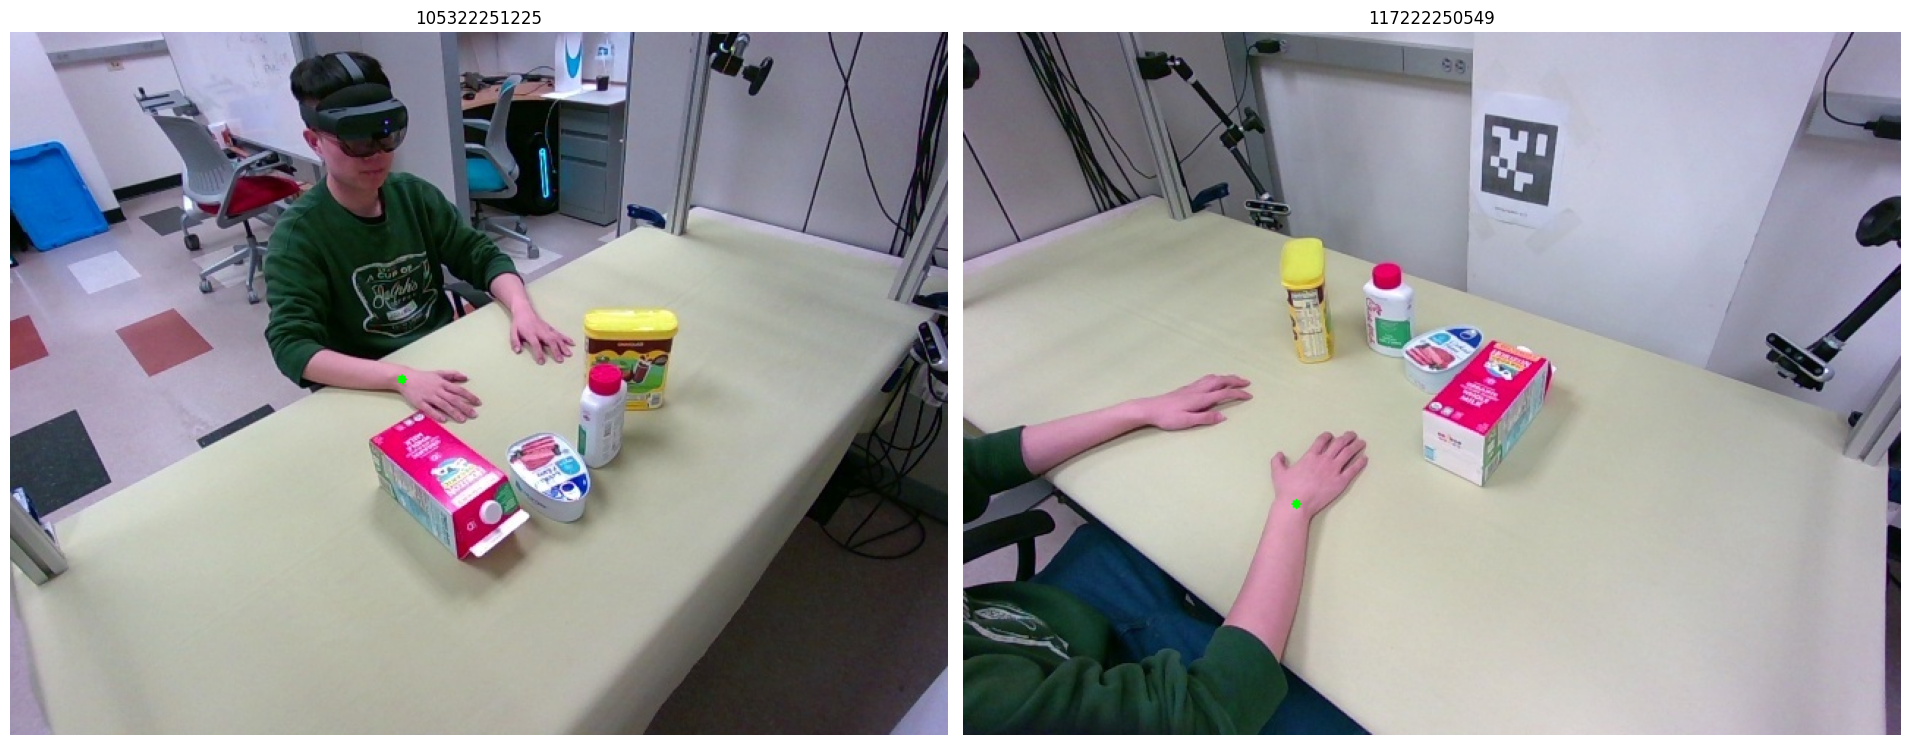

In [3]:
# read image from two cameras
rgb1 = read_rgb_image("../data/recordings/20231022_193630/105322251225/color_000000.jpg")
rgb2 = read_rgb_image("../data/recordings/20231022_193630/117222250549/color_000000.jpg")

# draw the landmarks
vis1 = draw_landmarks_on_image(rgb1, [uv1], color=(0, 255, 0))
vis2 = draw_landmarks_on_image(rgb2, [uv2], color=(0, 255, 0))

display_images([vis1, vis2], ["105322251225", "117222250549"])

## Read K matrix of the camera

In [4]:
# read K matrix from calibration file
K1 = read_K_matrix_from_json("../data/calibration/intrinsics/105322251225_640x480.json")
print(f"K1:\n {K1}")

K2 = read_K_matrix_from_json("../data/calibration/intrinsics/117222250549_640x480.json")
print(f"K2:\n {K2}")

K1:
 [[380.65616   0.      324.21024]
 [  0.      380.33176 241.03143]
 [  0.        0.        1.     ]]
K2:
 [[380.46677   0.      320.47305]
 [  0.      380.0273  238.19136]
 [  0.        0.        1.     ]]


## Read Extrinsics of the camera

- The loaded extrinsics are in the form of a 4x4 matrix.
- Ecah extrinsic matrix `RT` is the camera pose from the camera to master_camera.

In [5]:
# read extrinsics from calibration file
RTs, master_camera = read_extrinsics_from_json("../data/calibration/extrinsics/extrinsics_20231014/extrinsics.json")

RT1 = RTs["105322251225"]
RT1_inv = np.linalg.inv(RT1)

print(f"RT1:\n {RT1}")

RT2 = RTs["117222250549"]
RT2_inv = np.linalg.inv(RT2)

print(f"RT2:\n {RT2}")

RT1:
 [[-0.67091817 -0.4041614   0.6217092  -0.44285387]
 [ 0.71225345 -0.11797224  0.6919376  -0.81342024]
 [-0.20631026  0.90704787  0.3670151   0.60369873]
 [ 0.          0.          0.          1.        ]]
RT2:
 [[-0.54679996  0.5455328  -0.63514066  0.6089607 ]
 [-0.77057016 -0.03120429  0.6365909  -0.77244616]
 [ 0.32746202  0.8375084   0.43743366  0.62863815]
 [ 0.          0.          0.          1.        ]]


## Compute the Camera Projection Matrix

- The camera projection matrix is the product of the camera intrinsic matrix and the extrinsic matrix.
- The projection matrix is a 3x4 matrix.

$P = K \cdot RT$

In [6]:
# calculate the projection matrices 
P1 = K1 @ RT1_inv[:3, :]

print(f"P1:\n {P1}")

P2 = K2 @ RT2_inv[:3, :]

print(f"P2:\n {P2}")

P1:
 [[-5.38246765e+01  4.95456848e+02  4.04568634e+01  3.54754425e+02]
 [-3.86404419e+00  1.21910164e+02  4.33441345e+02 -1.64215027e+02]
 [ 6.21709108e-01  6.91937566e-01  3.67015094e-01  6.16595745e-01]]
P2:
 [[-411.58478     -89.16608     264.77423      15.31575   ]
 [  56.032272    139.77197     422.46902    -191.73529   ]
 [  -0.6351408     0.6365909     0.43743387    0.60352033]]


## Solve the Triangulation Problem

- The function takes the projection matrices of two cameras and the 2D image coordinates of the point.
- The matrix `A` is constructed by stacking the equations derived from the projection equations for each view.
- Singular Value Decomposition (SVD): The 3D point is the right singular vector corresponding to the smallest singular value of `A`.
- The solution is in homogeneous coordinates, so divide by the last element to get the 3D coordinates.

In [7]:
# triangulate two points
def triangulate_point(uv1, uv2, P1, P2):
    """ Triangulate a point from two views. 
    
    Args:
        uv1: 2D point in view 1, shape (2,)
        uv2: 2D point in view 2, shape (2,)
        P1: Projection matrix for view 1, shape (3, 4)
        P2: Projection matrix for view 2, shape (3, 4)
    Returns:
        3D point
    """

    # Construct the A matrix
    A = np.zeros((4, 4))
    A[0] = uv1[0] * P1[2] - P1[0]
    A[1] = uv1[1] * P1[2] - P1[1]
    A[2] = uv2[0] * P2[2] - P2[0]
    A[3] = uv2[1] * P2[2] - P2[1]

    # Perform SVD
    _, _, V = np.linalg.svd(A)

    # The last row of V gives the solution
    X = V[-1]

    # Convert from homogeneous to 3D coordinates
    return X[:3] / X[3]

In [8]:
point_3d = triangulate_point(uv1, uv2, P1, P2)

print(f"Triangulated 3D point:\n {point_3d}")


Triangulated 3D point:
 [ 0.33569545 -0.18490573  1.01870939]


## Visualize the Triangulated 3D Point on image

- First, we transform the 3D point from the master camera to the its own camera coordinate system.
- Next, we project the camera space 3D point to the image plane for the pixel coordinate `(u, v)`.
- Finally, we draw the `(u, v)` pixel on the image.

Projected uv_1: [267 236]
Projected uv_2: [227 322]


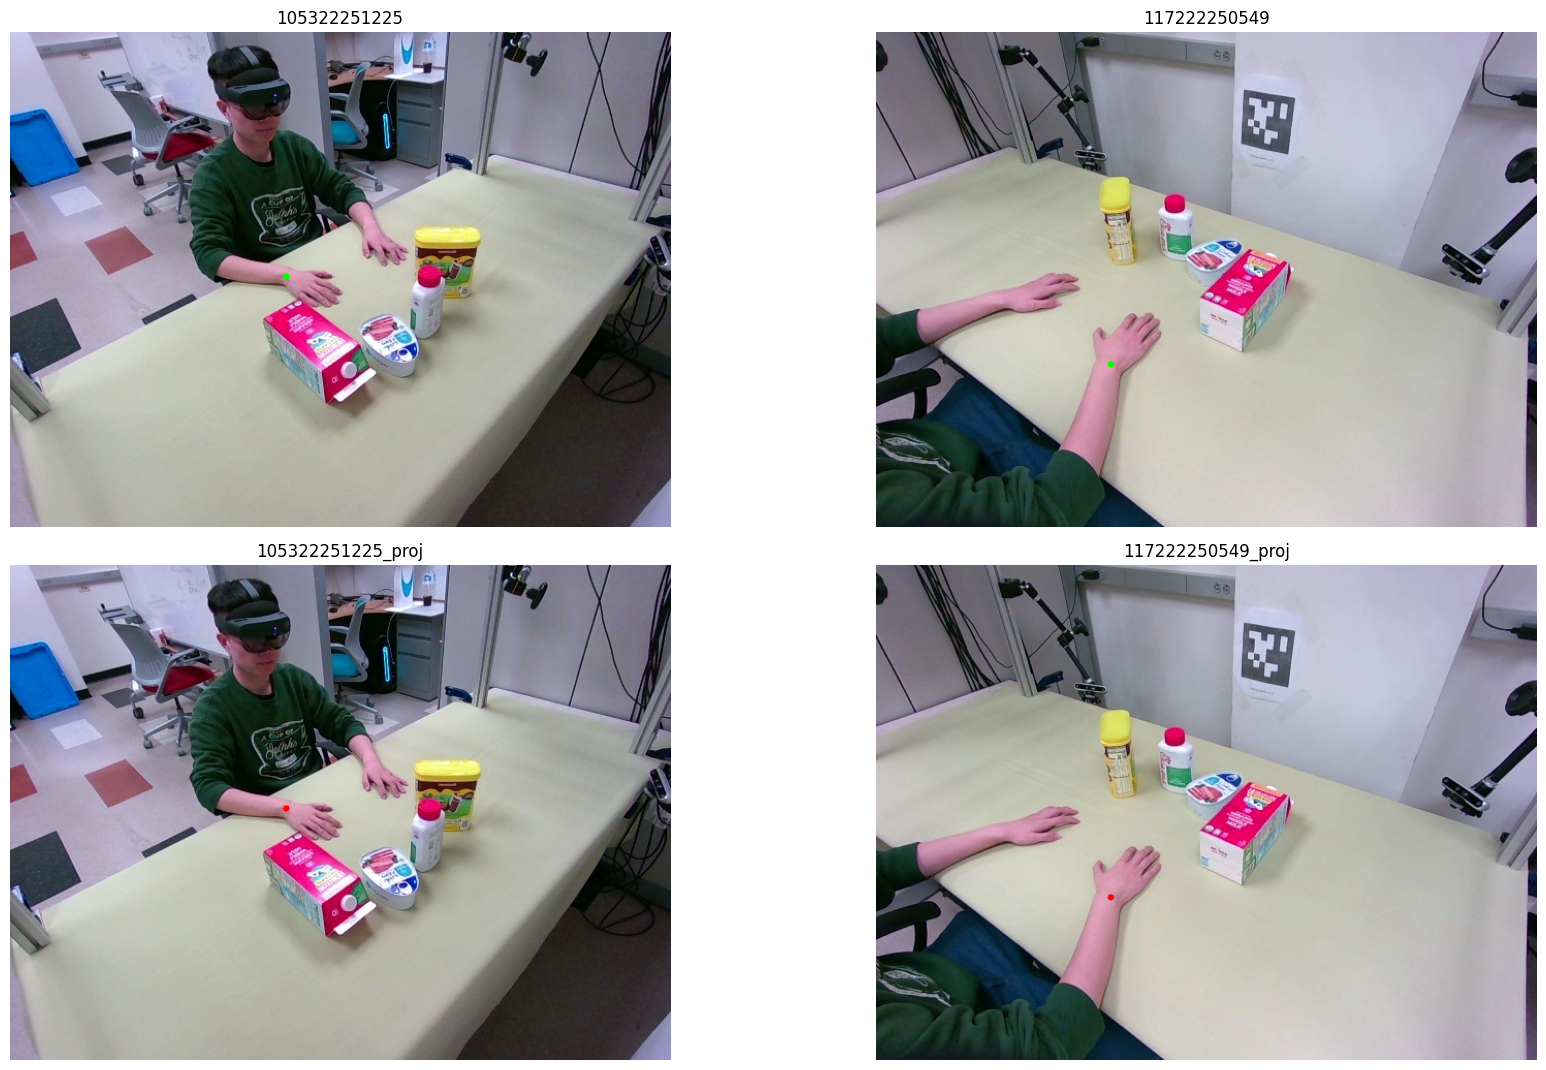

In [9]:
# transform the 3D point to the camera frame
point_3d_cam1 = apply_transformation([point_3d], RT1_inv)
point_3d_cam2 = apply_transformation([point_3d], RT2_inv)

# project the 3D point to the image
uv1_proj = get_uv_from_xyz(point_3d_cam1[0], K1[0,0], K1[1,1], K1[0,2], K1[1,2])
uv2_proj = get_uv_from_xyz(point_3d_cam2[0], K2[0,0], K2[1,1], K2[0,2], K2[1,2])

print(f"Projected uv_1: {uv1_proj}")
print(f"Projected uv_2: {uv2_proj}")

# draw the projected points
vis1_projected = draw_landmarks_on_image(rgb1, [uv1_proj], color=(255, 0, 0))
vis2_projected = draw_landmarks_on_image(rgb2, [uv2_proj], color=(255, 0, 0))

display_images(
    images=[vis1, vis2, vis1_projected, vis2_projected], 
    names=["105322251225", "117222250549", "105322251225_proj", "117222250549_proj"],
    max_cols=2,
)

## Visualize the Triangulated 3D Point in 3D

In [ ]:
# read depth images
depth1 = read_depth_image("../data/recordings/20231022_193630/105322251225/depth_000000.png")
depth2 = read_depth_image("../data/recordings/20231022_193630/117222250549/depth_000000.png")

# convert the depth images to meters
depth1 = depth1.astype(np.float32) / 1000.0
depth2 = depth2.astype(np.float32) / 1000.0

# get the normalized colors
colors1 = rgb1.reshape(-1, 3) / 255.0
colors2 = rgb2.reshape(-1, 3) / 255.0

# backproject the depth to 3D
points1 = deproject_depth_image(depth1, K1, RT1)
points2 = deproject_depth_image(depth2, K2, RT2)

merged_points = np.vstack([points1, points2])
merged_colors = np.vstack([colors1, colors2])

# create the point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(merged_points)
pcd.colors = o3d.utility.Vector3dVector(merged_colors)

# create the sphere at the triangulated point
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
sphere.paint_uniform_color([1, 0, 0])   # red color
sphere.translate(point_3d)

# visualize the 3D points
o3d.visualization.draw([pcd, sphere], point_size=1)

[Open3D INFO] Window window_0 created.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.


# Practice

Calculate the triangulated 3D points for below two cameras.

- camera `108222250342`: `uv1 = (358, 321)` for the wrist joint of the left hand.
- camera `046122250168`: `uv2 = (520, 257)` for the wrist joint of the left hand.

Refer to the code [python_quizs_answer2.py](./python_quizs_answer2.py) for the answer.


In [ ]:
uv1 = (358, 321)    # for camera 108222250342
uv2 = (520, 257)    # for camera 046122250168

# load the intrinsics
# write your code here

K1 = read_K_matrix_from_json("../data/calibration/intrinsics/108222250342_640x480.json")
print(f"K1:\n {K1}")

K2 = read_K_matrix_from_json("../data/calibration/intrinsics/046122250168_640x480.json")
print(f"K2:\n {K2}")

# load the extrinsics and invert them
# write your code here

RTs, master_camera = read_extrinsics_from_json("../data/calibration/extrinsics/extrinsics_20231014/extrinsics.json")

RT1 = RTs["108222250342"]
RT1_inv = np.linalg.inv(RT1)

print(f"RT1:\n {RT1}")

RT2 = RTs["046122250168"]
RT2_inv = np.linalg.inv(RT2)

print(f"RT2:\n {RT2}")

# calculate the projection matrices
# write your code here

P1 = K1 @ RT1_inv[:3, :]

print(f"P1:\n {P1}")

P2 = K2 @ RT2_inv[:3, :]

print(f"P2:\n {P2}")

# triangulate the points
# write your code here

def triangulate_point(uv1, uv2, P1, P2):
    """ Triangulate a point from two views. 
    
    Args:
        uv1: 2D point in view 1, shape (2,)
        uv2: 2D point in view 2, shape (2,)
        P1: Projection matrix for view 1, shape (3, 4)
        P2: Projection matrix for view 2, shape (3, 4)
    Returns:
        3D point
    """

      # Construct the A matrix
    A = np.zeros((4, 4))
    A[0] = uv1[0] * P1[2] - P1[0]
    A[1] = uv1[1] * P1[2] - P1[1]
    A[2] = uv2[0] * P2[2] - P2[0]
    A[3] = uv2[1] * P2[2] - P2[1]

      # Perform SVD
    _, _, V = np.linalg.svd(A)

      # The last row of V gives the solution
    X = V[-1]

      # Convert from homogeneous to 3D coordinates
    return X[:3] / X[3]

point_3d = triangulate_point(uv1, uv2, P1, P2)

print(f"Triangulated 3D point:\n {point_3d}")

# visualize the triangulated point in 3D
# read the color & depth images
# write your code here

depth1 = read_depth_image("../data/recordings/20231022_193630/108222250342/depth_000000.png")
depth2 = read_depth_image("../data/recordings/20231022_193630/046122250168/depth_000000.png")

# convert the depth images to meters
# write your code here

depth1 = depth1.astype(np.float32) / 1000.0
depth2 = depth2.astype(np.float32) / 1000.0

# get the normalized colors
# write your code here

colors1 = rgb1.reshape(-1, 3) / 255.0
colors2 = rgb2.reshape(-1, 3) / 255.0

# backproject the depth to 3D
# write your code here

points1 = deproject_depth_image(depth1, K1, RT1)
points2 = deproject_depth_image(depth2, K2, RT2)

# merge the points and colors
# write your code here

merged_points = np.vstack([points1, points2])
merged_colors = np.vstack([colors1, colors2])

# create the point cloud
# write your code here

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(merged_points)
pcd.colors = o3d.utility.Vector3dVector(merged_colors)

# create the sphere at the triangulated point
# write your code here

sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
sphere.paint_uniform_color([1, 0, 0])   # red color
sphere.translate(point_3d)

# visualize the 3D points
# write your code here

o3d.visualization.draw([pcd, sphere], point_size=1)